In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

Missing values has been imouted using KNN and columns with less tha 5% missing values has been dropped

In [3]:
df=pd.read_csv("Fraud.csv")
missing_percentage = df.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
fraud_bool                          0.0
income                              0.0
name_email_similarity               0.0
prev_address_months_count           0.0
current_address_months_count        0.0
customer_age                        0.0
days_since_request                  0.0
intended_balcon_amount              0.0
payment_type                        0.0
zip_count_4w                        0.0
velocity_6h                         0.0
velocity_24h                        0.0
velocity_4w                         0.0
bank_branch_count_8w                0.0
date_of_birth_distinct_emails_4w    0.0
employment_status                   0.0
credit_risk_score                   0.0
email_is_free                       0.0
housing_status                      0.0
phone_home_valid                    0.0
phone_mobile_valid                  0.0
bank_months_count                   0.0
has_other_cards                     0.0
proposed_credit_limit              

Applying SMOTE For imbalancing

Class distribution:
fraud_bool
0    988971
1     11029
Name: count, dtype: int64


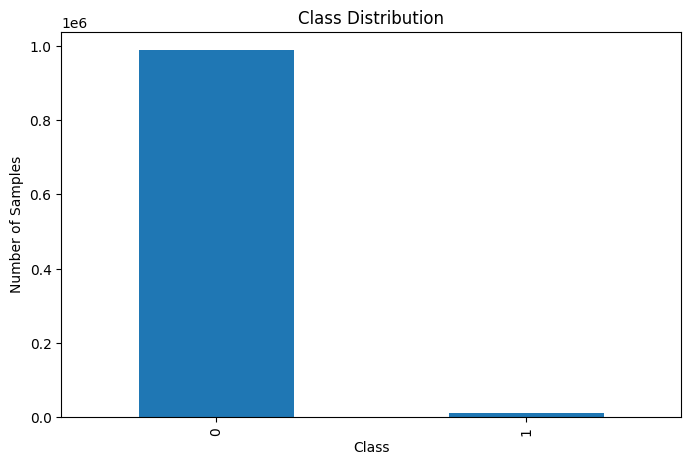

Imbalance ratio (max/min): 89.67


In [4]:
target_counts = df['fraud_bool'].value_counts()
print("Class distribution:")
print(target_counts)
plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

In [5]:
non_numeric_columns = df.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_columns)
if len(non_numeric_columns) > 0:
    X = pd.get_dummies(df, drop_first=True)
    print("Converted non-numeric columns to numeric using one-hot encoding.")
smote = SMOTE(random_state=42)
y = df['fraud_bool']  # Replace 'fraud_bool' with the actual target column name
X_resampled, y_resampled = smote.fit_resample(X, y)
print("SMOTE applied successfully. Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

Non-numeric columns: Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')
Converted non-numeric columns to numeric using one-hot encoding.
SMOTE applied successfully. Class distribution after resampling:
fraud_bool
0    988971
1    988971
Name: count, dtype: int64


Outlier (Trimming , Mean/Median , Flooring & Clapping))

In [6]:
def detect_outlier_columns(df, threshold=1.5):
    outlier_columns = []
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Check if any value is outside the bounds
        if ((df[column] < lower_bound) | (df[column] > upper_bound)).any():
            outlier_columns.append(column)
    return outlier_columns

Columns with outliers: ['fraud_bool', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'device_distinct_emails_8w']


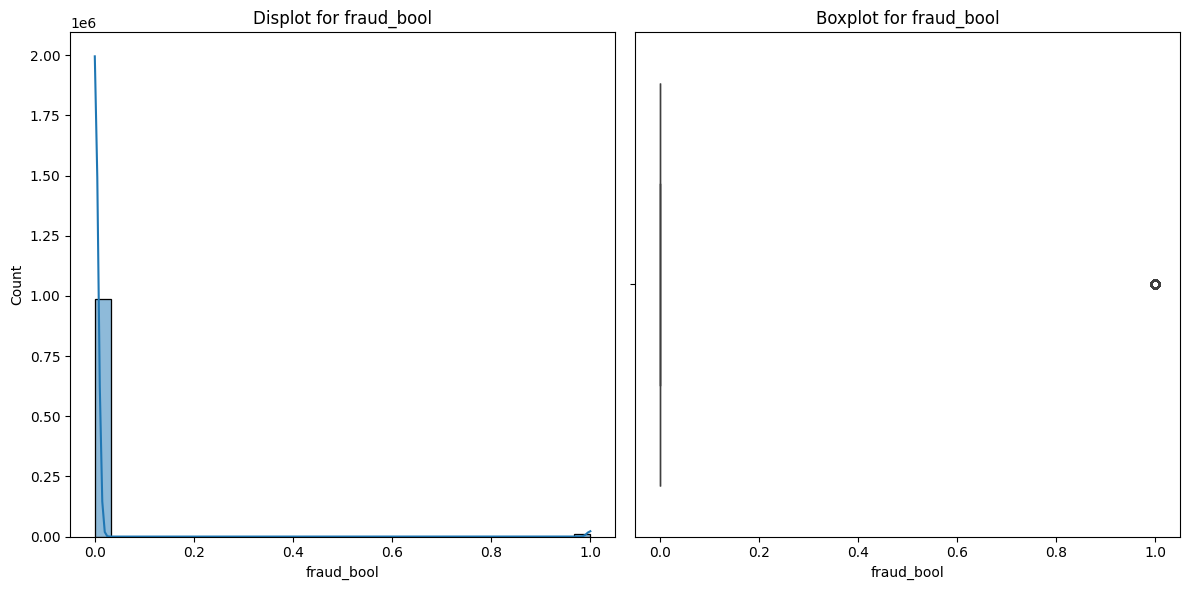

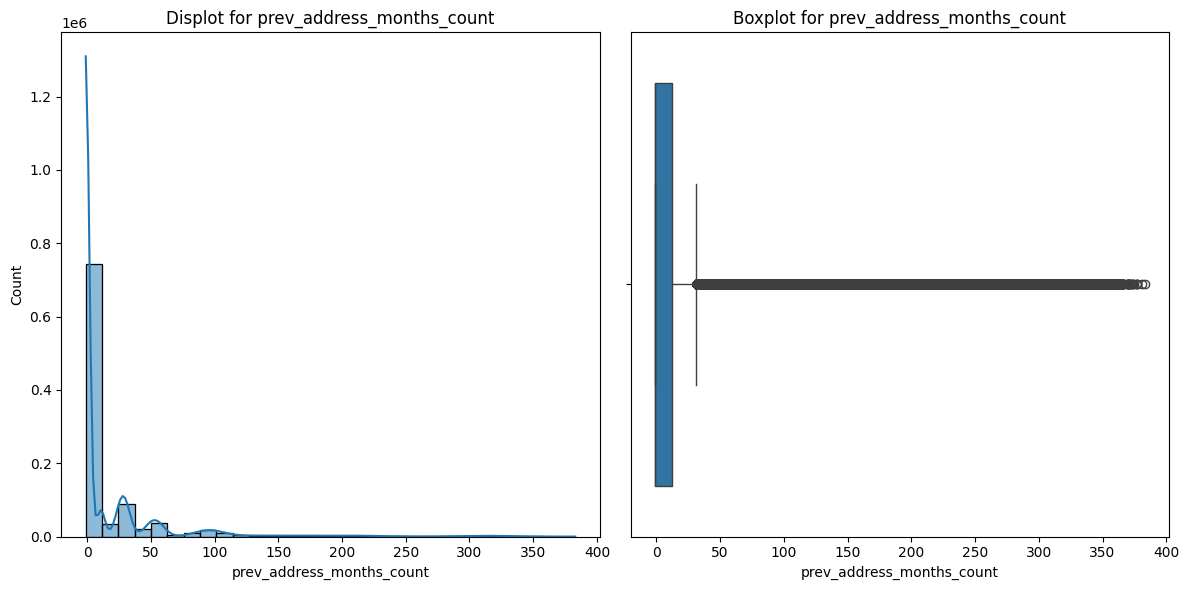

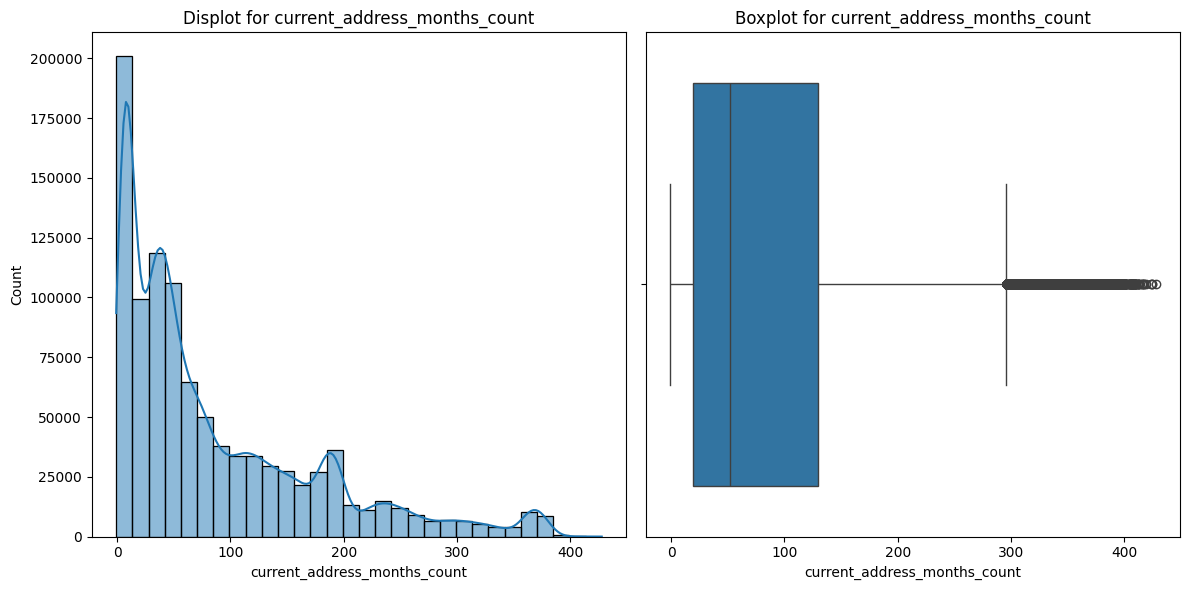

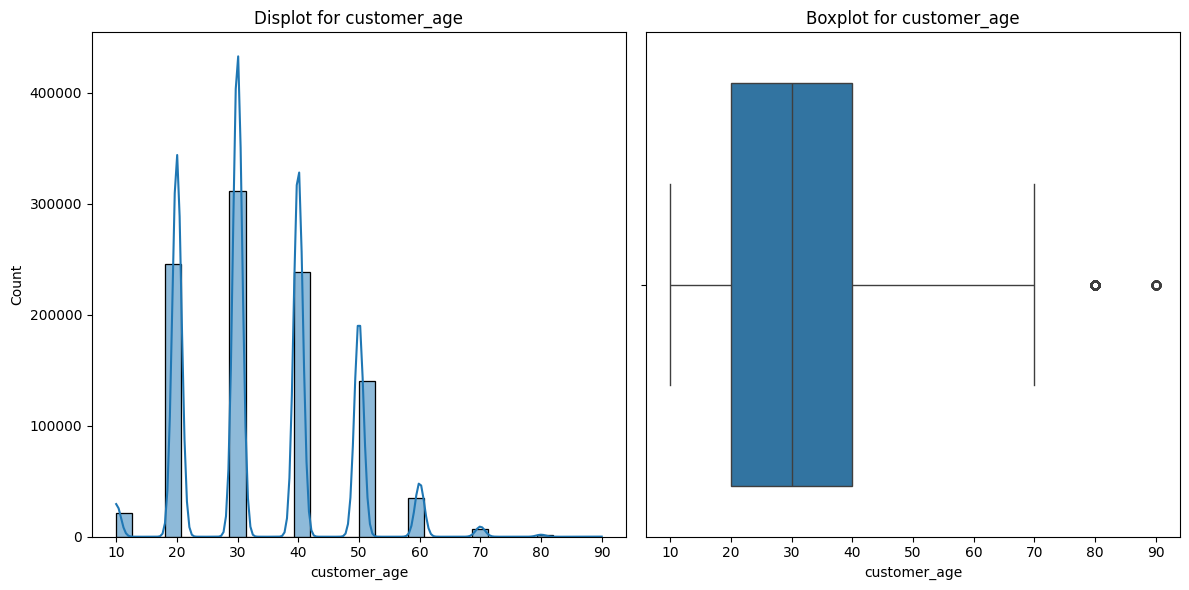

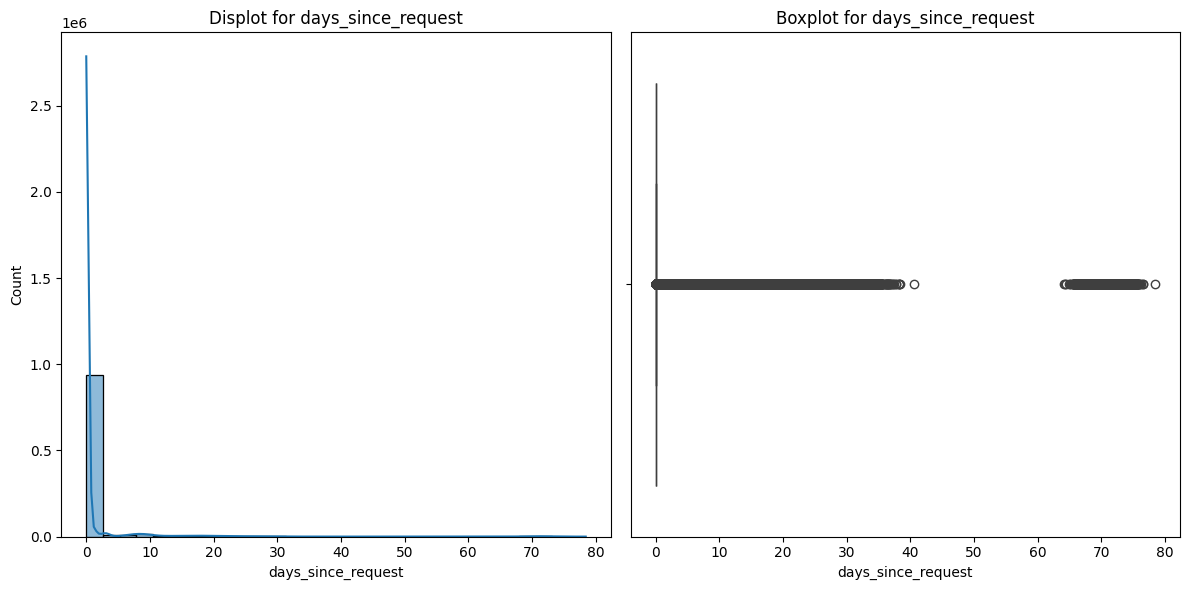

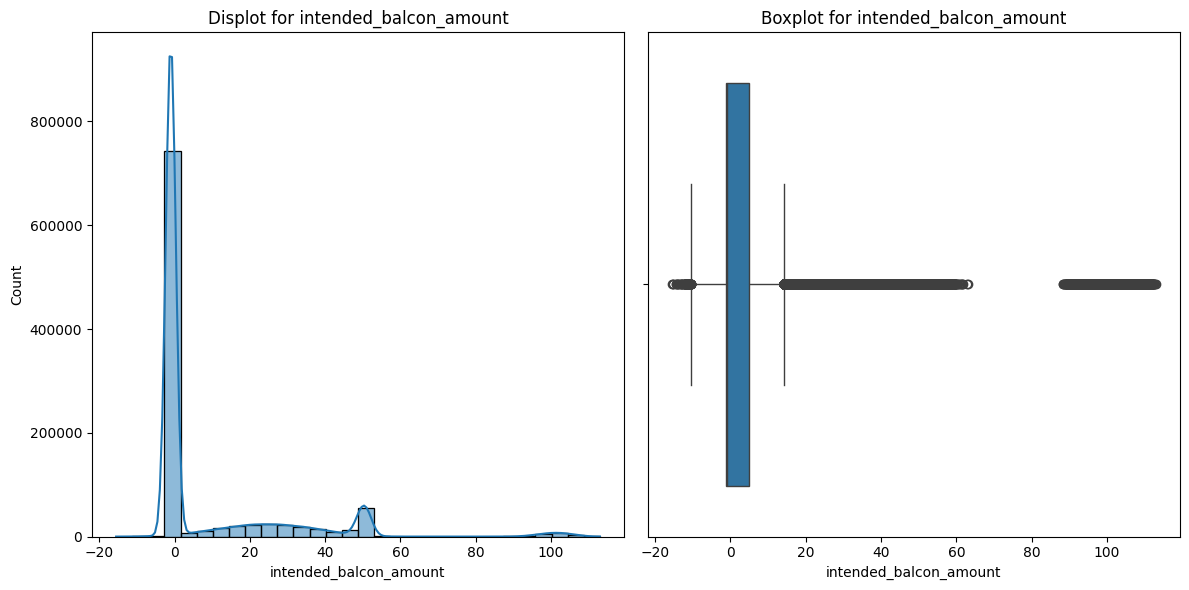

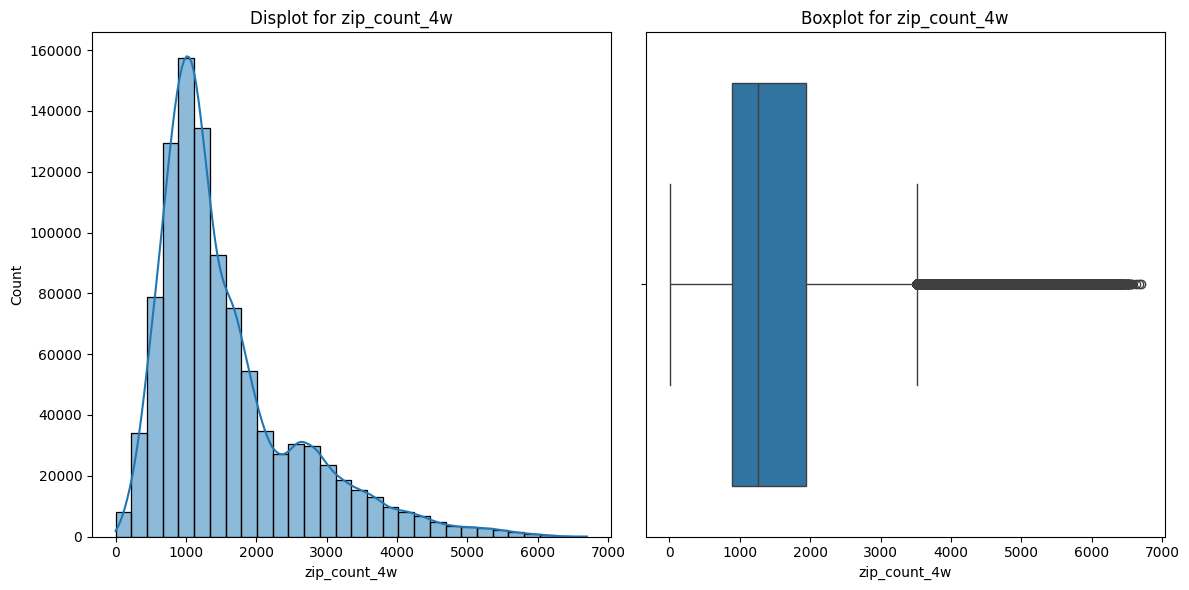

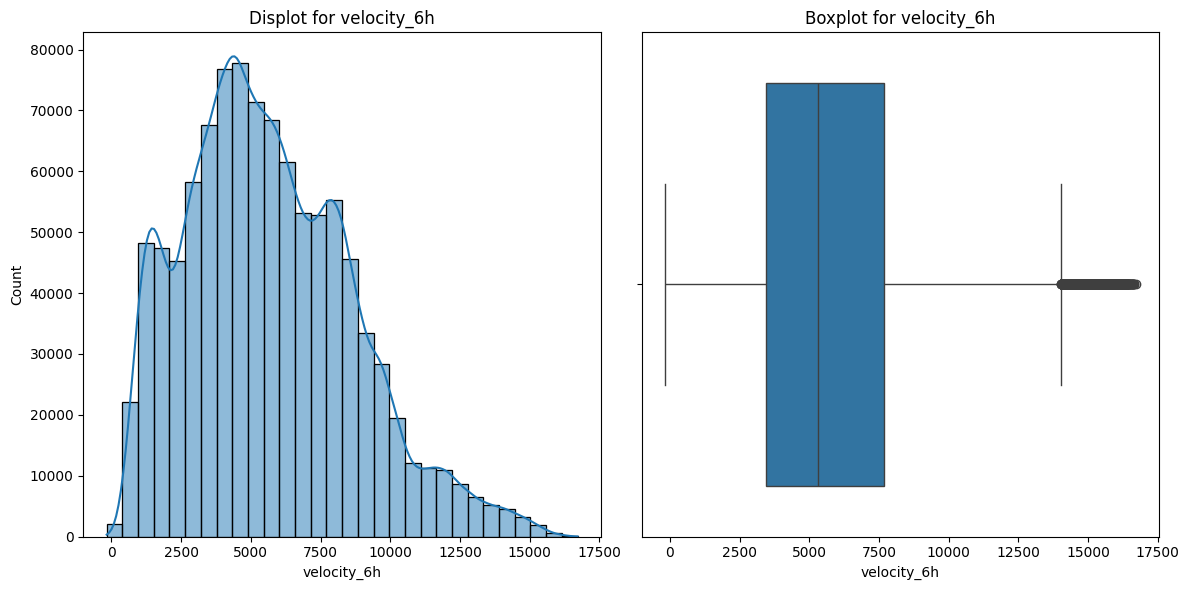

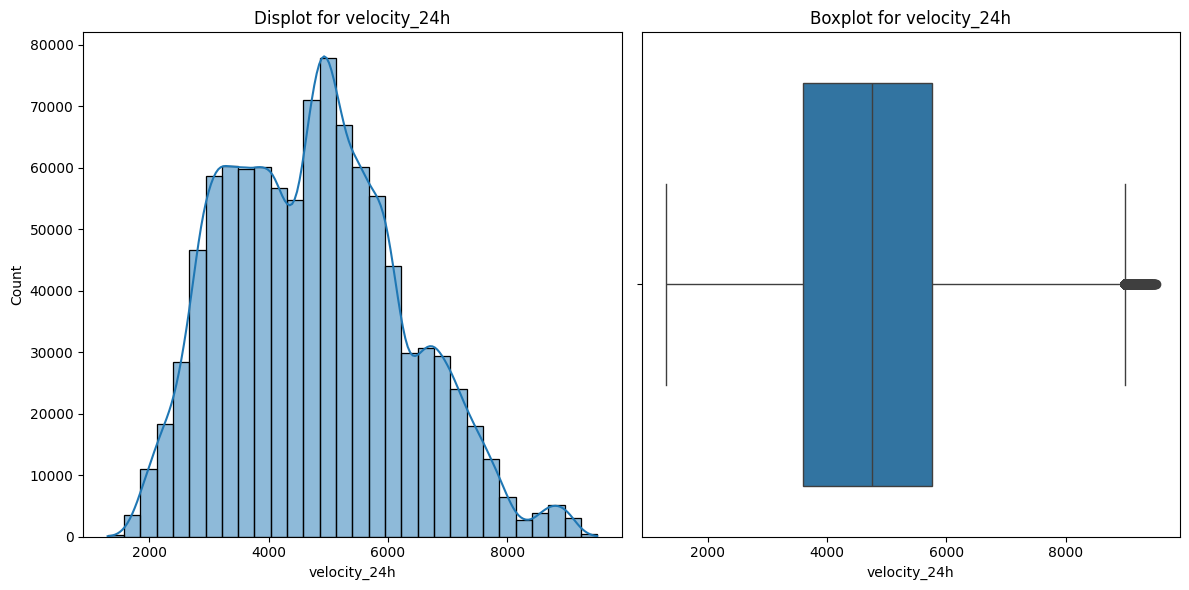

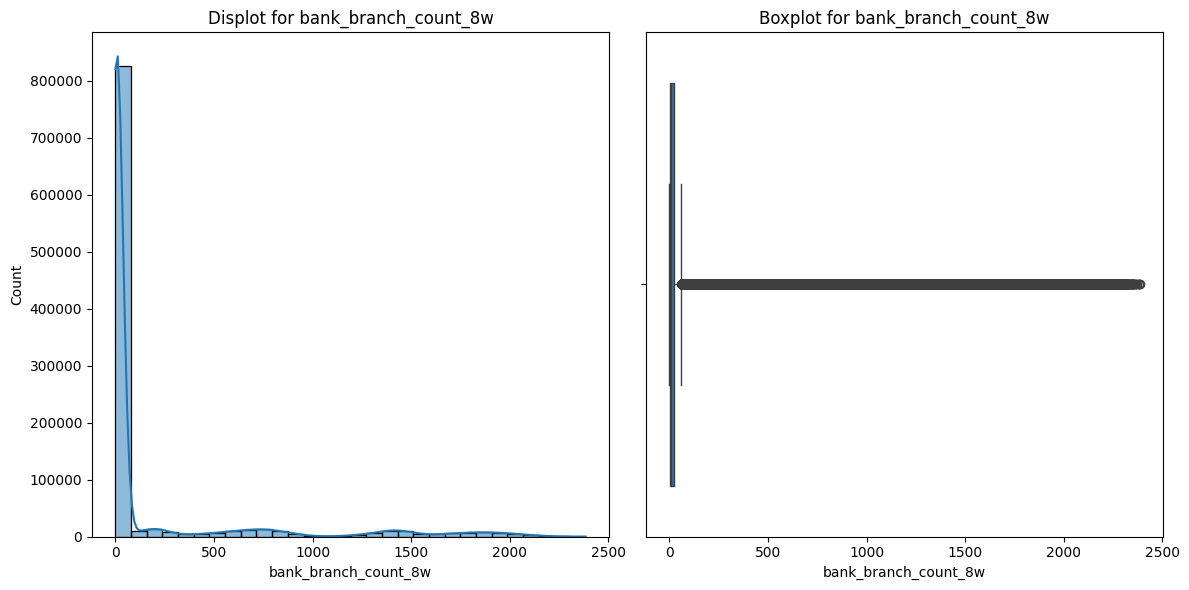

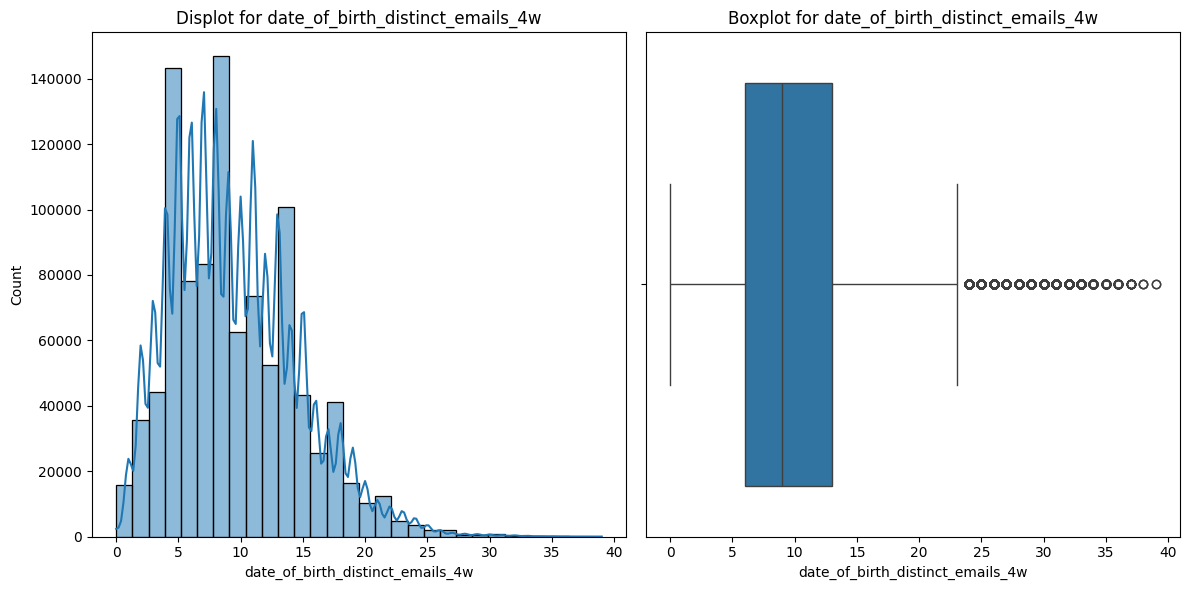

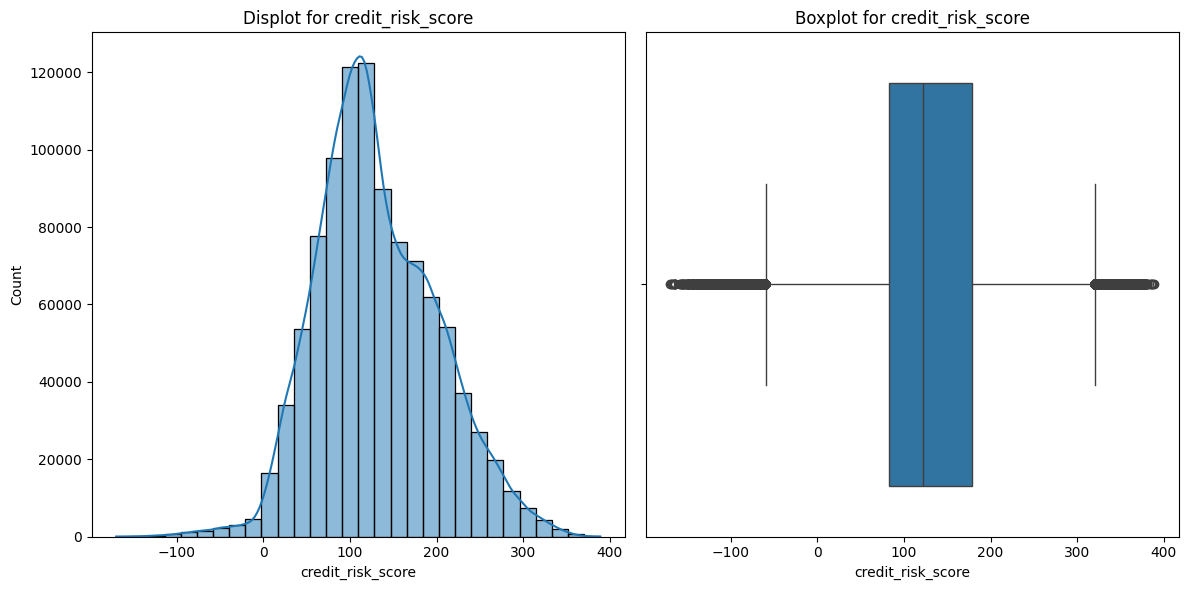

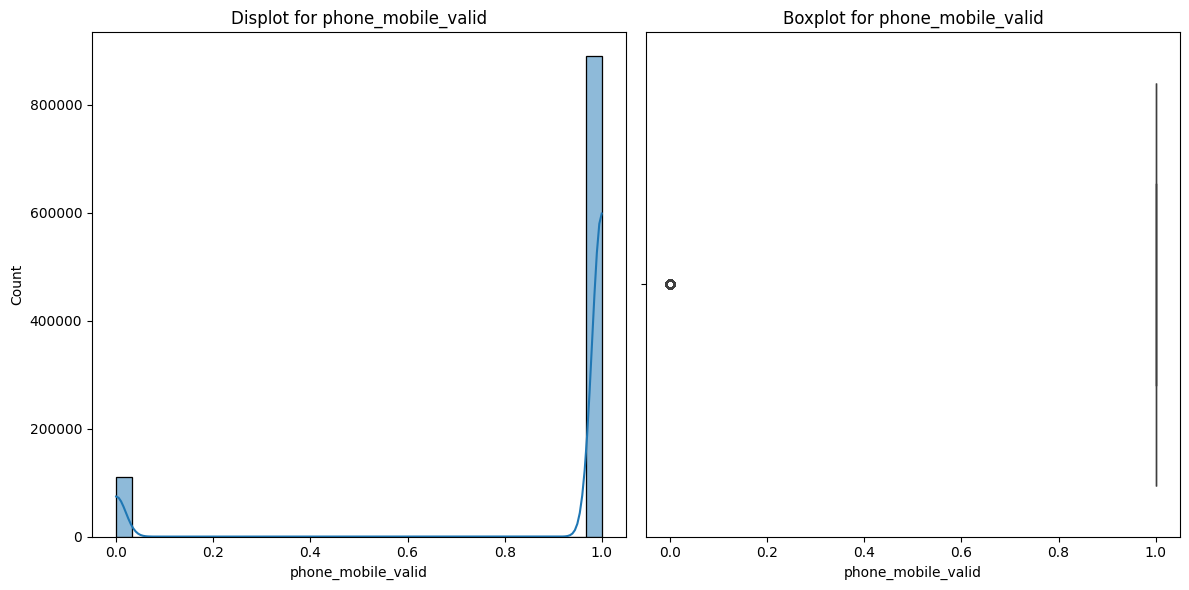

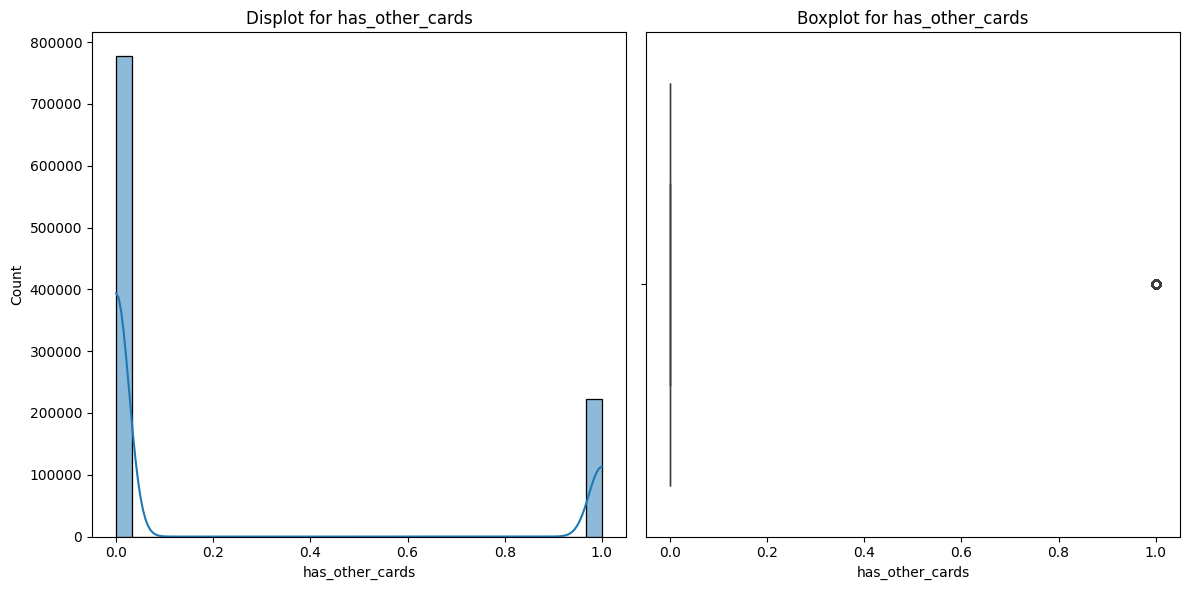

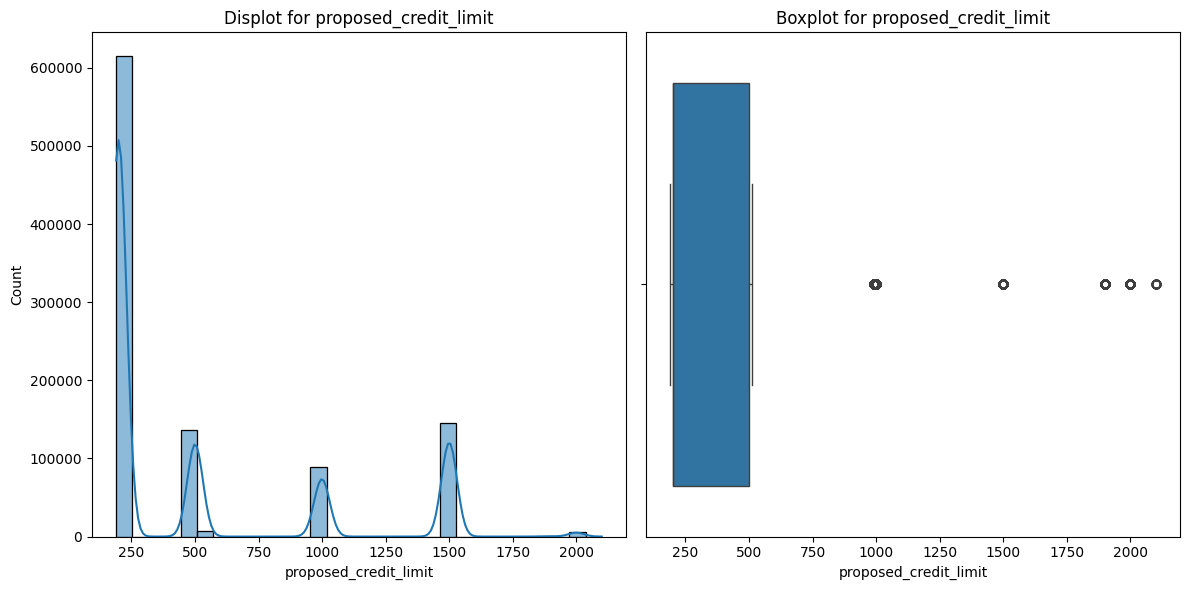

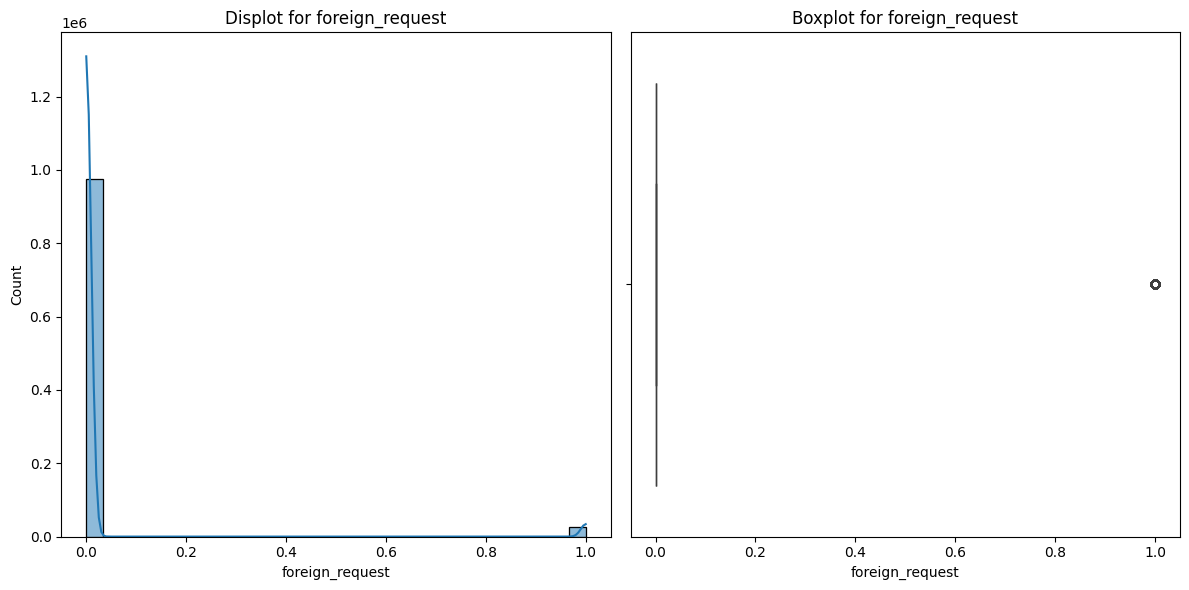

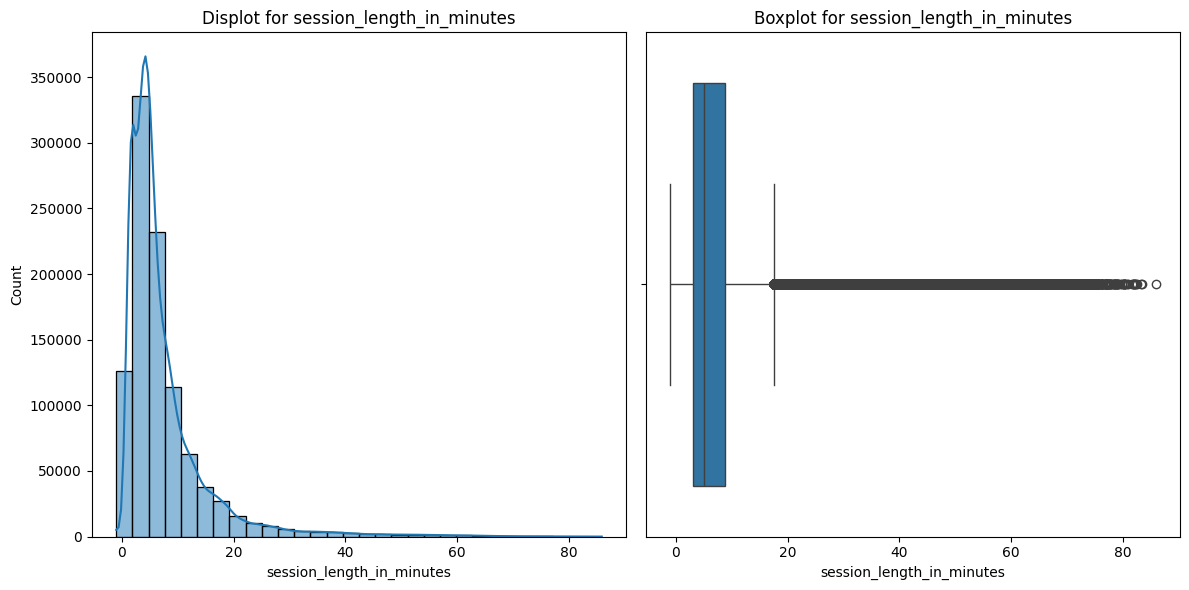

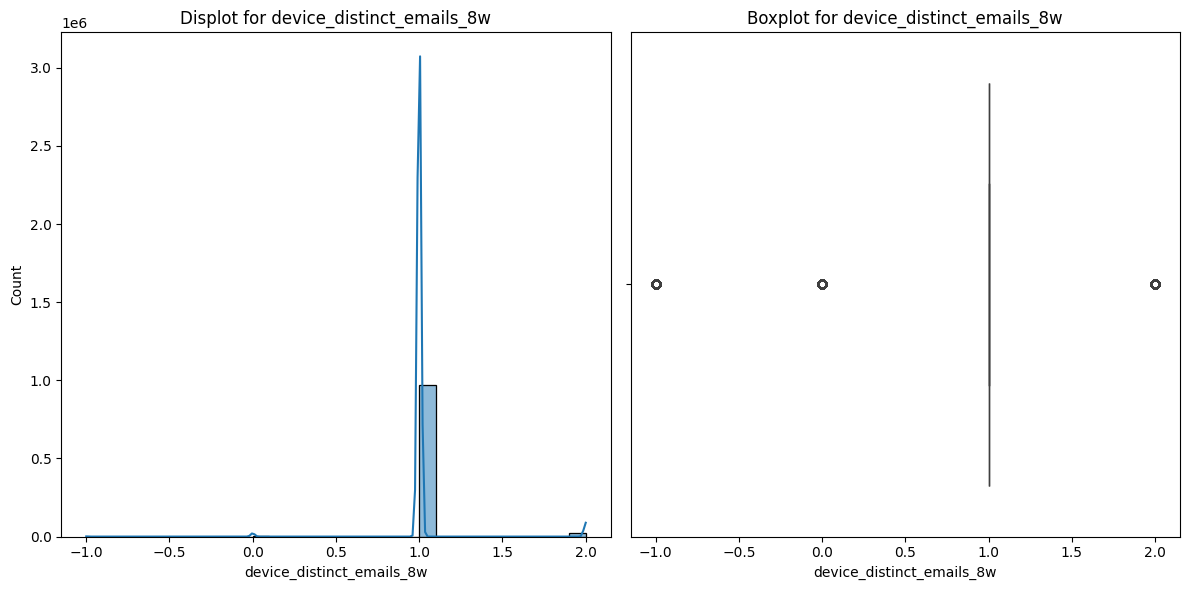

In [7]:
numerical_columns_with_outliers = detect_outlier_columns(df)
print(f"Columns with outliers: {numerical_columns_with_outliers}")
for column in numerical_columns_with_outliers:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"Displot for {column}")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot for {column}")
    plt.tight_layout()
    plt.show()

In [9]:
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR   
    # Check for outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return not outliers.empty  # Returns True if outliers are present, False otherwise
# Check for outliers in each numeric column
outlier_report = {col: find_outliers_iqr(df, col) for col in df.select_dtypes(include='number').columns}
def trim_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    trimmed_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return trimmed_data
numeric_columns = df.select_dtypes(include='number').columns
for col in numeric_columns:
    if find_outliers_iqr(df, col):
        df = trim_outliers_iqr(df, col)
print("Data after trimming outliers:")
print(df.shape)

Data after trimming outliers:
(113248, 32)


In [10]:
lower_quantile = 0.01  # 1st percentile
upper_quantile = 0.99  # 99th percentile
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    lower_bound = df[col].quantile(lower_quantile)
    upper_bound = df[col].quantile(upper_quantile)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
print("Shape of the dataframe after flooring and capping:", df.shape)

Shape of the dataframe after flooring and capping: (113248, 32)


In [11]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        median_value = df[col].mean()  #median()
        df[col].fillna(median_value, inplace=True)
print("Shape of the dataframe after mean/median imputation:", df.shape)

Shape of the dataframe after mean/median imputation: (113248, 32)


Normalization (Min Max Scaling & One Hot Encoding)

In [12]:
scaler = MinMaxScaler()
numeric_columns = df.select_dtypes(include='number').columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
print("Data after Min-Max scaling:")
print(df.head())
df = pd.get_dummies(df, drop_first=True)
print("Data after one-hot encoding:")
print(df.head())
print("Number of columns after one-hot encoding:", df.shape[1])

Data after Min-Max scaling:
     fraud_bool  income  name_email_similarity  prev_address_months_count  \
17          0.0   0.625               0.471085                        0.0   
91          0.0   1.000               0.738565                        0.0   
93          0.0   1.000               0.904759                        0.0   
107         0.0   0.750               0.480432                        0.0   
112         0.0   0.000               0.378654                        0.0   

     current_address_months_count  customer_age  days_since_request  \
17                       0.123457           0.6            0.869299   
91                       0.004115           0.4            0.629447   
93                       0.020576           0.2            0.363673   
107                      0.251029           0.6            0.488643   
112                      0.106996           0.4            0.419168   

     intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
17

PCA to Reduce Dimension

In [13]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
pca = PCA(n_components=0.90)  # Retain 90% of the variance
X_pca = pca.fit_transform(X_resampled_scaled)
print("Explained variance ratio of each component:")
print(pca.explained_variance_ratio_)
print(f"Number of components chosen to retain 90% variance: {pca.n_components_}")
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
print("PCA-transformed dataset (first 5 rows):")
print(pca_df.head())
print("Number of columns after PCA:",pca_df.shape[1])
pca_df.shape

Explained variance ratio of each component:
[0.08261135 0.06056493 0.04277726 0.03646067 0.03432867 0.03313265
 0.0293458  0.02762191 0.02492836 0.02386679 0.02365228 0.02326154
 0.02229206 0.02192441 0.02169876 0.02140214 0.0212971  0.02127069
 0.02121626 0.02118501 0.02106411 0.02069949 0.02054599 0.02026184
 0.01974379 0.01924015 0.0191342  0.01893641 0.01834633 0.01823905
 0.01792329 0.01674553 0.01634172 0.01578903 0.01441277 0.0138346 ]
Number of components chosen to retain 90% variance: 36
PCA-transformed dataset (first 5 rows):
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.463143 -2.935175 -0.992684 -1.156860 -1.933473 -2.718368  1.598745   
1 -3.062584 -1.001669  0.343498 -1.443865 -1.526195 -1.472912 -0.223008   
2 -1.269502 -1.290943 -0.232762 -1.355710  2.012984 -1.036233 -0.605327   
3 -3.503523 -2.374004  0.877529 -0.418073  1.139653 -1.133777 -0.819237   
4 -2.671992 -0.753823 -0.793268 -0.332331 -0.526885 -1.104548  2.482314   

       

(1977942, 36)

Logistic Regression 

In [14]:
X_train_pca, X_test_pca, y_train_resampled, y_test_resampled = train_test_split(X_pca, y_resampled, test_size=0.3, random_state=42)
log_reg_pca = LogisticRegression(max_iter=500)
log_reg_pca.fit(X_train_pca, y_train_resampled)
y_pred_pca = log_reg_pca.predict(X_test_pca)
print("Accuracy Score:", accuracy_score(y_test_resampled, y_pred_pca))
print("Confusion Matrix:\n", confusion_matrix(y_test_resampled, y_pred_pca))
print("Classification Report:\n", classification_report(y_test_resampled, y_pred_pca))

Accuracy Score: 0.9823335012968015
Confusion Matrix:
 [[292147   4814]
 [  5669 290753]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    296961
           1       0.98      0.98      0.98    296422

    accuracy                           0.98    593383
   macro avg       0.98      0.98      0.98    593383
weighted avg       0.98      0.98      0.98    593383



ROC AUC Score: 1.00


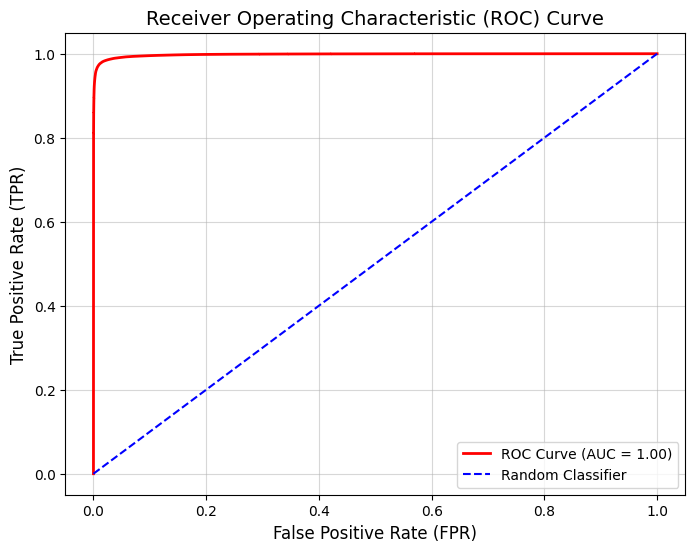

In [15]:
y_test_pred_proba = log_reg_pca.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_resampled, y_test_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.2f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.5)
plt.show()

Testing on real data

Confusion Matrix:
[[292147   4814]
 [  5669 290753]]


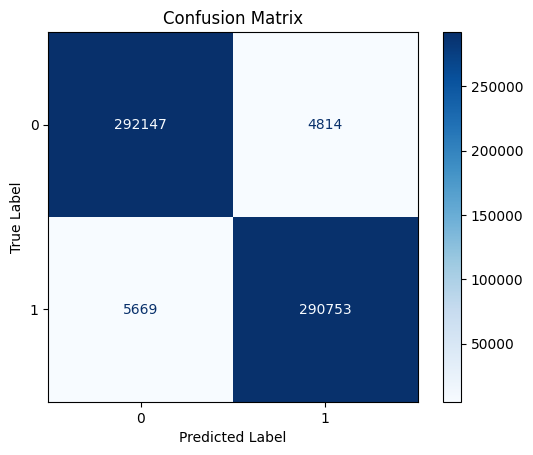

In [21]:
y_pred_pca = log_reg_pca.predict(X_test_pca)
cm = confusion_matrix(y_test_resampled, y_pred_pca)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg_pca.classes_)
disp.plot(cmap="Blues", values_format='d')
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
plt.grid(False)  
plt.show()

In [18]:
def predict_fraud():
    input_data = {
        'feature1': float(input("Enter value for Name Email Similarity: ")),
        'feature2': float(input("Enter value for Age: ")),
        'feature3': input("Enter value for Payment Type (Categorical): "),  
        'feature1': float(input("Enter Credit Risk Score: ")),
        
    }
    input_df = pd.DataFrame([input_data])
    input_df = pd.get_dummies(input_df, drop_first=True)
    missing_cols = set(X.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0
    input_df = input_df[X.columns]
    input_df_scaled = scaler.transform(input_df)
    input_pca = pca.transform(input_df_scaled)
    prediction = log_reg_pca.predict(input_pca)
    prediction_prob = log_reg_pca.predict_proba(input_pca)
    if prediction[0] == 1:
        print("The model predicts: Fraudulent transaction.")
    else:
        print("The model predicts: Non-fraudulent transaction.")
    print(f"Prediction probabilities: {prediction_prob[0]}")
predict_fraud()

Enter value for Name Email Similarity:  0.33
Enter value for Age:  30
Enter value for Payment Type (Categorical):  AA
Enter Credit Risk Score:  130


The model predicts: Non-fraudulent transaction.
Prediction probabilities: [0.8790651 0.1209349]
